In [1]:
import stan
import nest_asyncio
import seaborn
nest_asyncio.apply()


print("Hello, world!", stan.__version__, seaborn.__version__)

Hello, world! 3.9.1 0.13.2


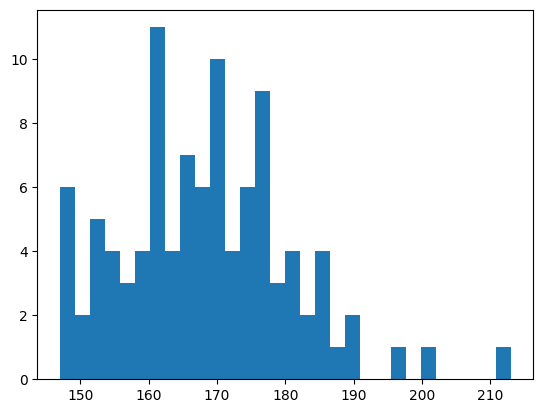

In [2]:
import scipy.stats as sc
import numpy as np
import matplotlib.pyplot as plt

#Hyperparameters
a = 10.
b = 0.1

#Sample parameter from prior
theta = sc.gamma.rvs(a, scale=1/b)

# sample n observations conditional on theta
n = 100

x = sc.poisson.rvs(theta, size=n)

plt.hist(x, 30);

In [3]:
#Define and build Stan model

poisson_gamma_model = """
    data {
        int<lower=0> N;
        array[N] int<lower=0> x;
        real<lower=0> a;
        real<lower=0> b;
    }
    parameters {
        real<lower=0> theta;                // Poisson mean
    }
    model {
        theta ~ gamma(a, b);
        
        for (n in 1:N) {
          x[n] ~ poisson(theta);            // iid Poisson(theta)
        }
    }
"""

data = {'N': len(x),'x': x.tolist(), 'a': a, 'b': b}
posterior = stan.build(poisson_gamma_model, data=data, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


Sampling:   0%
Sampling:  55% (1100/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan__mnn0in2/model_kjv4vtd2.stan', line 12, column 8 to column 28)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be posit

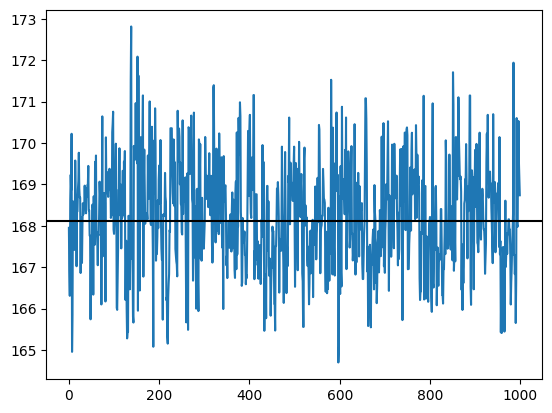

In [4]:
#MCMC sampling 

fit = posterior.sample(num_chains=1, num_samples=1000)

theta_sample = fit['theta'][0]

plt.plot(theta_sample)
plt.axhline(theta, color='k');

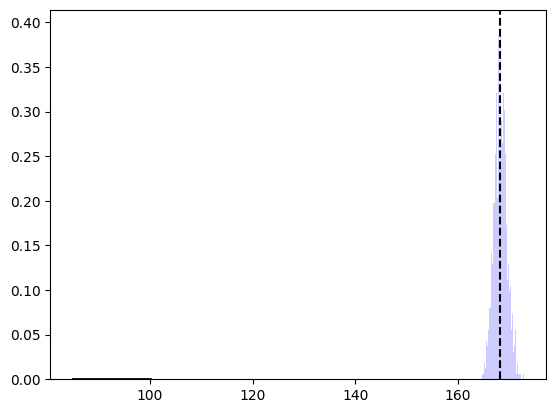

In [5]:
x_grid = np.linspace(85, 100, 1000)

#Sampled posterior
plt.hist(theta_sample, 50, density=True, color='b', alpha=0.2)

#True posterior
plt.plot(x_grid, sc.gamma(a + sum(x), scale = 1 / (b + len(x))).pdf(x_grid), color="k",linestyle="-", lw=2)
plt.axvline(theta, color='k', linestyle='--');